In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
import os

GROUND_TRUTH_PATH = '/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv'
IMAGE_DIR ='/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_DEPTH = 3

BATCH_SIZE = 32

Using TensorFlow backend.


In [2]:
def read_split_data(gt_path=GROUND_TRUTH_PATH, rn_seed=42):
    np.random.seed(rn_seed)
    gt = pd.read_csv(gt_path)
    gt.drop(['UNK'], axis=1, inplace=True)
    for ind in range(len(gt)):
        gt.image[ind] += '.jpg'
    val_inds = (np.random.rand(len(gt)//5) * len(gt)).astype(int)
    tr_gt = gt.drop(val_inds, axis=0)
    va_gt = gt.iloc[val_inds]
    return gt, tr_gt, va_gt


ground_truth, train_gt, valid_gt = read_split_data()
labels = list(ground_truth.columns[1:])
labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

In [3]:
def get_train_generator(df, x_col, y_cols, image_dir=IMAGE_DIR, shuffle=True, batch_size=BATCH_SIZE, seed=1, target_w=IMAGE_WIDTH, target_h=IMAGE_HEIGHT):
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [4]:
def get_valid_generator(valid_df, train_df, x_col, y_cols, image_dir=IMAGE_DIR, sample_size=100, batch_size=BATCH_SIZE, seed=1, target_w=IMAGE_WIDTH, target_h=IMAGE_HEIGHT):
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_generator

In [5]:
train_gen = get_train_generator(train_gt, "image", labels)
valid_gen = get_valid_generator(valid_gt, train_gt, "image", labels)

getting train generator...
Found 20763 validated image filenames.
getting train and valid generators...
Found 20763 validated image filenames.
Found 5066 validated image filenames.


(32, 224, 224, 3)
(32, 8)


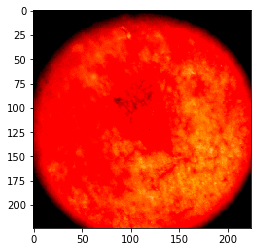

In [6]:
x, y = train_gen.__getitem__(0)
print(x.shape)
print(y.shape)
plt.imshow(x[0])

**Weighted Loss Function**

In [7]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    return weighted_loss


neg_weights = np.mean(train_gen.labels, axis=0)
pos_weights = 1 - neg_weights

**Focal Loss Function**

In [8]:
# def focal_loss(gamma=2., alpha=4.):
#     gamma = float(gamma)
#     alpha = float(alpha)

#     def focal_loss_fixed(y_true, y_pred):
#         """
#             Source: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
#         """
#         epsilon = 1.e-9
#         y_true = tf.convert_to_tensor(y_true, tf.float32)
#         y_pred = tf.convert_to_tensor(y_pred, tf.float32)

#         model_out = tf.add(y_pred, epsilon)
#         ce = tf.multiply(y_true, -K.log(model_out))
#         weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
#         fl = tf.multiply(alpha, tf.multiply(weight, ce))
#         reduced_fl = tf.reduce_max(fl, axis=1)
#         return tf.reduce_mean(reduced_fl)
#     return focal_loss_fixed

In [9]:
def get_densenet_model(labels, loss, trainable=True, im_width=IMAGE_WIDTH, im_height=IMAGE_HEIGHT, im_depth=IMAGE_DEPTH):
    # create the base pre-trained model
    base_model = DenseNet121(weights='imagenet', include_top=False)

    x = base_model.output

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss=loss)
    return model

# define loss function
model_loss = get_weighted_loss(pos_weights, neg_weights)
# create and compile model
model = get_densenet_model(labels, model_loss)
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________

**Fit, Save, and Evaluate Model**

In [10]:
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              steps_per_epoch=train_gen.samples//BATCH_SIZE, 
                              validation_steps=valid_gen.samples//BATCH_SIZE, 
                              epochs=5)

Train for 648 steps, validate for 158 steps
Epoch 1/5
648/648 [==============================] - 1210s 2s/step - loss: 0.6845 - val_loss: 0.6418
Epoch 2/5
648/648 [==============================] - 1065s 2s/step - loss: 0.5958 - val_loss: 0.6458
Epoch 3/5
648/648 [==============================] - 1067s 2s/step - loss: 0.5551 - val_loss: 0.6328
Epoch 4/5
648/648 [==============================] - 1063s 2s/step - loss: 0.5189 - val_loss: 0.6571
Epoch 5/5
648/648 [==============================] - 1073s 2s/step - loss: 0.4905 - val_loss: 0.5850


In [11]:
model.save("densenet121_5_epoch.h5")

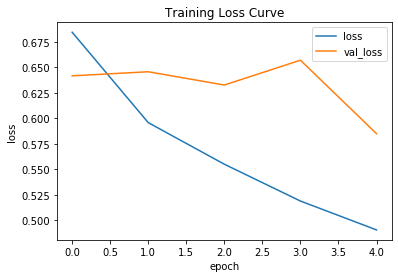

In [12]:
# Loss Plots for train and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.legend(['loss','val_loss'])
plt.show()

In [13]:
# # Accuracy Plots for train and validation
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.title("Training Accuracy Curve")
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()

KeyError: 'accuracy'

**Load Model**

In [ ]:
# model = keras.models.load_model("/kaggle/input/isic-2019-vgg19/vgg19_5_epoch.h5")

In [ ]:
# predictions
predicted_vals = model.predict_generator(valid_gen, steps=valid_gen.samples)

**Plot Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
y_pred = np.array([np.argmax(pred) for pred in predicted_vals])
y_true = np.array([np.argmax(truth) for truth in valid_gen.labels])
print("y_true:", y_true)
print("y_pred:", y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
conf_mat

In [ ]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


auc_rocs = get_roc_curve(labels, predicted_vals, valid_gen)